In [1]:
#NOTE: we assume all time series data in PST time. Only time we are working with non PST data is when 
# we receive data and then convert. See get_occupancy function for how to do that.
# base imports
import time
from collections import defaultdict
%matplotlib inline
import pandas as pd
from copy import copy
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pytz
tz = pytz.timezone("US/Pacific")
import doctest
import matplotlib.lines as plt_line
import matplotlib

In [2]:
# for fetching data
from xbos import get_client
from xbos.services.pundat import DataClient, timestamp, make_dataframe, merge_dfs
from xbos.services.hod import HodClient

In [3]:
# get a bosswave client
c = get_client(entity="/Users/Daniel/CIEE/SetUp/ciee_readonly.ent", agent="127.0.0.1:28589")
# get a HodDB client
hod = HodClient("ciee/hod", c)
# get an archiver client
archiver = DataClient(c,archivers=["ucberkeley"])

Saw [ciee/hod] HodDB 3 seconds 34.382 ms ago
Saw [ucberkeley] archiver 3 seconds 542.3 ms ago


# Find histogram of occupancy

In [18]:
def get_occupancy(start='"2017-09-01 00:00:00 MST"', end='"2017-09-12 00:00:00 MST"', time_steps="15T"):
    """Returns a dictionary {Zone: occupancy_data} where the occupancy data is a pandas
    dataframe, where each column represents a sensor. It is indexed as timeseries data with time_steps as given.
    It has all the data in the range of times start to end as given.
    Note, the data is given in MST time as that is how it stores. We will convert it in the function to PST.
    Parameters:
        start: When should the data start. Has to be a string of a string '"Time"'.
        end: when should the data end. Has to be a string of a string '"Time"'.
        time_steps: in what intervals (start, start+time+steps) do we want to look at data. 
                    If a sensor regiester someone in those 15minutes,
                    then we will treat the whole 15 minute as being occupied. (Is this a valid assumption?) 
    Returns:
        A dataframe. Only returns the data for whole days. Will truncate edge days if needed.
    IMPROVEMENT TO ME: maybe make it such that we don't have to store the data in a different cell. such that
            we only ever have to make a call to this function, and it will somehow store the already pulled function, 
            such that it doesn't have to pull it over and over again.
    """
    # define a Brick query to get the occupancy information
    q = """SELECT ?zone ?sensor_uuid WHERE {
       ?zone rdf:type brick:HVAC_Zone .
       ?zone bf:hasPart ?room .
       ?sensor bf:isLocatedIn ?room .
       ?sensor rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
       ?sensor bf:uuid ?sensor_uuid .
    };
    """
    result = hod.do_query(q)['Rows']
    occupancy_sensors = defaultdict(list)
    for sensor in result:
        occupancy_sensors[sensor['?zone']].append(sensor['?sensor_uuid'])
    zone_df = defaultdict()
    for zone, sensor_uuid in occupancy_sensors.items():
        occupancy_data = make_dataframe(archiver.data_uuids(sensor_uuid, start, end, timeout=300))
        occupancy_df = merge_dfs(occupancy_data, resample=time_steps, do_max=True)
        idx = occupancy_df.index
        idx = idx.tz_localize(pytz.utc).tz_convert(tz)
        occupancy_df.index = idx
        #The following will make sure that we only have whole days in the returned DF. Only because of timezones.
        # Need to truncate ends since we don't have more data.
        if occupancy_df.index[0].time() > pd.Timestamp("00:00:00").time():
            temp = occupancy_df.index[0]
            d_temp = pd.Timestamp(temp + pd.Timedelta("1 days"))
            d_temp = d_temp.replace(hour=0,minute=0,second=0)
            occupancy_df = occupancy_df.loc[d_temp:]

        if occupancy_df.index[-1].time() < pd.Timestamp("23:45:00").time():
            temp = occupancy_df.index[-1]
            d_temp = pd.Timestamp(temp + pd.Timedelta("-1 days"))
            d_temp = d_temp.replace(hour=23,minute=45,second=0)
            occupancy_df = occupancy_df.loc[:d_temp]
        
        zone_df[zone] = 1*(occupancy_df > 0)


    return zone_df

In [19]:
# store data in this cell, so we do not have to call get_occupancy at all times
# WE NEED TO CALL THIS CELL ONCE FROM HERE ON FORWARD!
# MAKE SURE WE ONLY HAVE FULL DAYS. OTHERWISE THE FUNCTIONS WON'T WORK ALL TOO WELL at edge days.
# STILL FAILING WITH FULL DAYS.
zone_df_data = get_occupancy(start='"2017-09-01 00:07:00 MST"', end='"2017-10-01 00:07:00 MST"')

In [20]:
def compute_envelope(start="08:00:00", end="18:00:00", time_steps="15T"):
    """Computes an envelope for a day. Will be filled with 1's from start to end, 
    and the time series will have a period of time_steps.
    Parameters:
            start: When the envelope should start. Provide pandas time string. should be less than end.
            end: When the envelope should end. Provdie pandas time string. should be greater than start.
            time_steps: the period of the indexing. Taken to be that if at time 08:15:00 we have a one, then 
                        in the period between 08:15:00 and 08:30:00 someone was by the occupancy sensor."""
    time = pd.DatetimeIndex(freq='15T', start='2017-01-01 00:00:00', end='2017-01-01 23:59:59')
    envelope = pd.Series(data=0, index=time)
    envelope.loc['2017-01-01 ' + start:'2017-01-01 ' + end] = 1
    return envelope

def hamming_distance(arr, compare_to):
    """Returns hamming distance of two numpy arrays. 
    >>> a = np.array([1,0,1])
    >>> b = np.array([0,1,0])
    >>> hamming_distance(a, b)
    3
    >>> c = np.array([1])
    >>> hamming_distance(a, c)
    1
    
    The last output is a result from appending an array of zeros to c to make a and c equal length."""
    return np.count_nonzero(arr != compare_to)

In [21]:
def get_zone_occupancy(cond=(lambda x: True)):
    """Returns the logical or of all sensors in a zone.
    Parameters:
        cond: A function on a timestamp by which to filter the data."""
    result = defaultdict()
    for zone, df in zone_df_data.items():
        temp = df[df.index.map(cond)]
        result[zone] = temp.apply(lambda x: max(x), axis = 1)
    return result

def get_building_occupany(cond=(lambda x: True)):
    """Returns the logical or of all sensors.
    Parameters:
        cond: A function on a timestamp by which to filter the data.
    Returns:
        pd.DataFrame"""
    
    result = None
    for key, value in zone_df_data.items():
        if result is None:
            result = value
        else:
            result = pd.concat([result, value], axis=1)
    result = result[result.index.map(cond)]
    result = result.apply(lambda x: max(x), axis=1)
    return pd.DataFrame(data=result.values, columns=["Occupied"], index=result.index)

In [138]:
# Improvement: Right now only works for a df with one columns or pandas series
def compute_histogram(data, cond, equivalence_classes):
    """Creates a weighted histogram of the data. The histograms will be computed for all equivalent dates for the
    given equivalence. For example, if we give the equivalence relation (lambda x, e: x.dayofweek == e) 
    and the list of equivalences we want to find [0,1,2,3,4,5,6], 
    then we will get a dictionary {e: histogram for equivalent days}. So, for Monday I would get
    {0: histogram for all mondays}. Furthermore, every equivalence is given a weight which depends on the equivalence
    class and the input day. So, we could weight days which are further in the past less. 
    Frequency of histrogram will be the same as the data given.
    Parameters:
        data: The data for which to compute the histogram.
        cond_weight: The condition by which to establish equivalence or the equialence relation and returns the weight
            of the specific equivalence and day. Has to have the input format
            cond(day, equivalence). (Returns: int: weight). A weight of 0 means no equivalence and a weight of one means
            full equivalence. 
        equivalence_classes: The equivalences we want to find.
    Returns:
        A dictionary of the format {e: [histogram for this element (a day) as a pandas Series, number of equivalent
        days]} """
    histograms = defaultdict()
    for e in equivalence_classes:
        data["temp"] = data.index.map(lambda d: cond(d, e)) # since it should also affect the column of the weights, so I add it to the dataframe.
        temp = data[data["temp"]>0] # we only care about the days where the weights are nonzero.
        temp = temp["Occupied"] * temp["temp"] # to scale by the importance of each day.
        g_obj = temp.groupby(by=lambda x: x.time())
        temp = g_obj.sum()
        histograms[e] = [temp, int(g_obj.count()[0])] # Since every entry has the same number of days, we can just get the first.
    return histograms


# Improve that it could take more than one column.
def plot_histogram(his, e_mapping, e, plot_with_envelope=False):
    """Plots the histograms for the data (assumes only one column).
    Parameters:
        his: The histogram to plot. Should be a pandas Series.
        e_mapping: The mapping from the numerical representation of a equivalence class to something more representative. 
                    e.g. 4 would map to Friday.
        e: the equivalence classes to consider.
        plot_with_envelope: Plots the given envelope we have. Fromats it such that it fits to the index of
                        the output of compute_histogram. Also, will be scaled by the max of each histogram to 
                        make it more visible."""
    if plot_with_envelope:
        envelope = compute_envelope().groupby(lambda x: x.time()).sum()
    # Plots a histogram for equivalence class.
    for i in e:
        plt.figure(figsize=(12,8))
        plt.plot(his[i][0])
        if plot_with_envelope:
            plt.plot(envelope*max(his[i][0]))
        plt.title("Histogram for: "+ e_mapping[i] +".")
        plt.xlabel("Time of day.")
        plt.ylabel("Number of days the region was occupied.")
        plt.show()

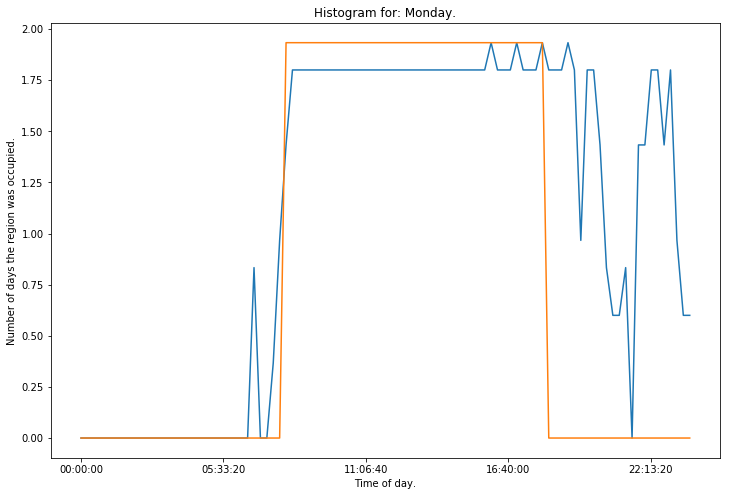

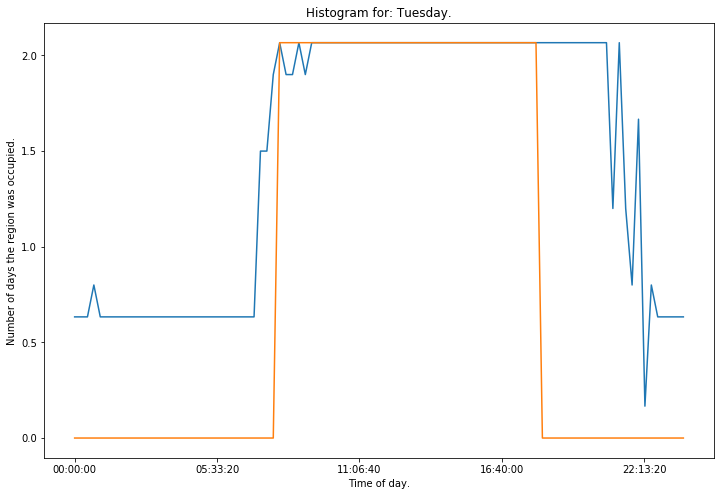

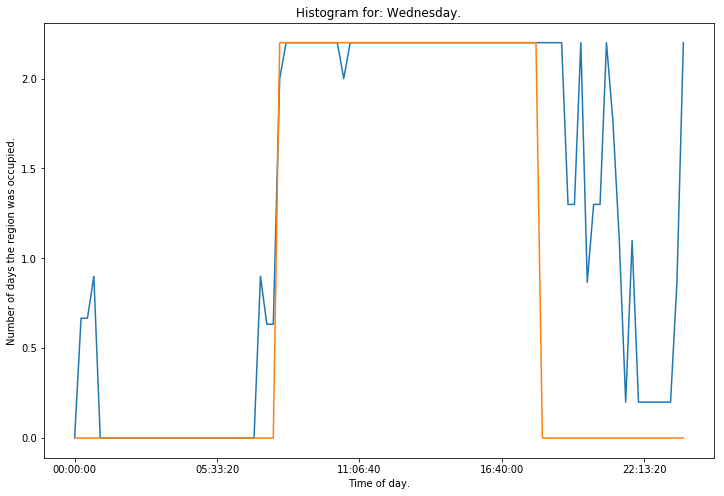

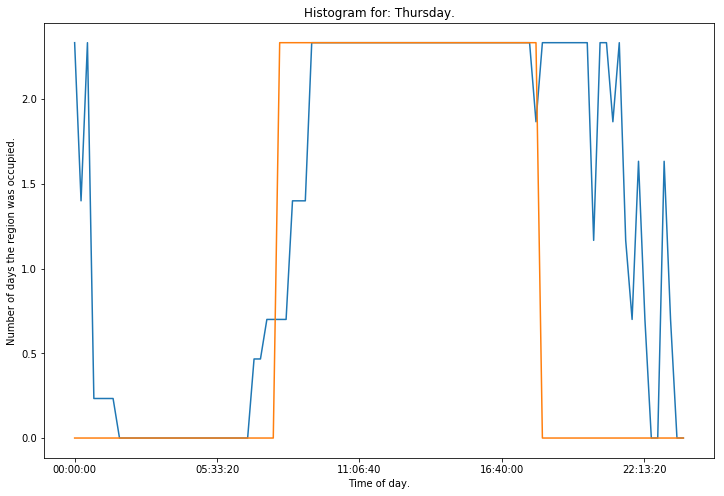

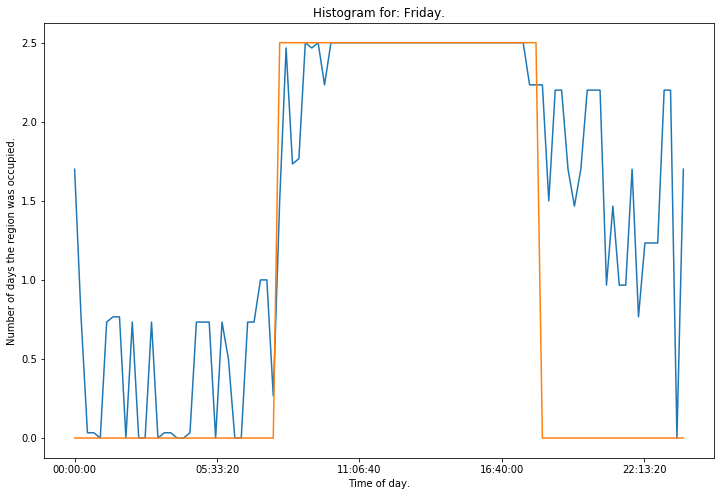

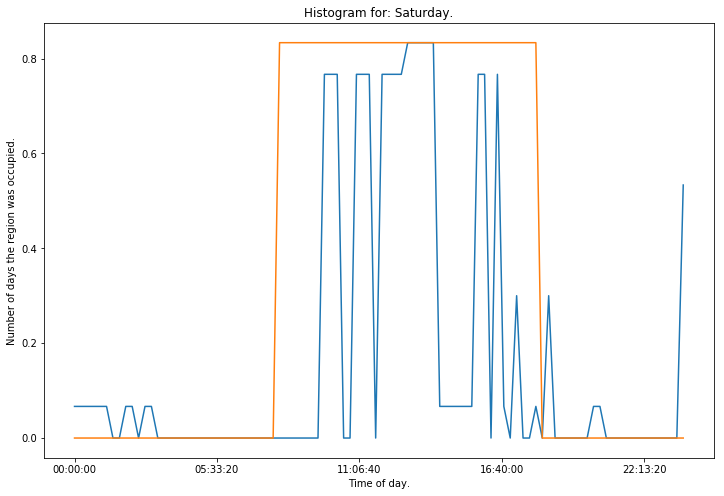

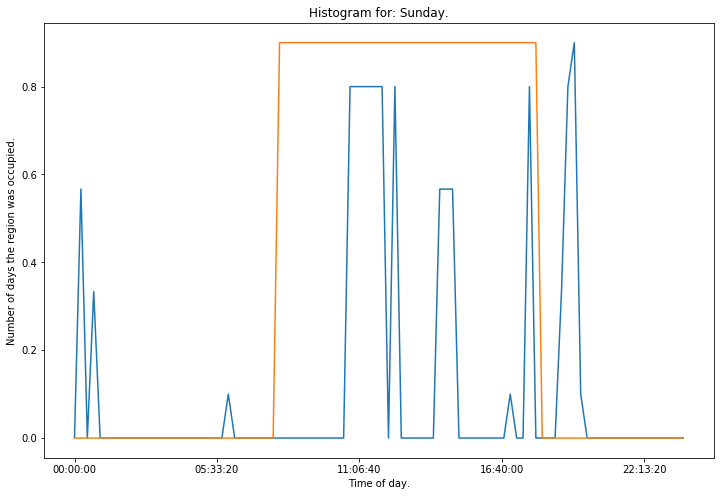

In [139]:
# Plot weekday histogram
weekday_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
e = list(range(7))
buildings = get_building_occupany()
his = compute_histogram(buildings, lambda d, e: d.day/30.0*(d.weekday() == e), e) # giving all days equal weight
plot_histogram(his, weekday_mapping, e, True)

In [311]:
# IMPROVEMENT. Implemented it on a room basis for now. It will plot every day of the data given on one plot.
# ALSO, check why there are solid lines sometimes.
def plot_distribution_overlay(data, env, kind="room"):
    """Plots the occupancy distributions of rooms for several days on graphs. The distributions are represented by
    lines. If the line is visible at a point, then the room was occupied. If there is a gap between lines, then in that
    time frame the room was unoccupied. The x axis will be the hours of a day, and a graph will have several lines,
    each representing a different room for the day given.
    Parameters:
            data: The data for which to find the distributions. Index should be time series, and columns should be boolean
                    arrays. Will plot for every column, and the number of lines will correspond to number of rooms/columns
                    in the data given.
            env: We also plot the envelope for reference.
            kind: The kind of data we are plotting. On a room basis for now. """
    weekday_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    dates = data.index.normalize().unique().date # get the unique days in the data given. 
    
    for date in dates:
        data_use = data[data.index.map(lambda x: x.date == date)]
        env_use = pd.DataFrame(data=env.values, columns=["Envelope"], index=data_use.index)
        def f(x, height, c):
            """Finds wether or not a room was occupied at the time. Does not return a value
            but modiefies the attributes of the function. Improvement: Don't use functions as classes."""
            t = x["time"]
            curr_occ = x[c] == 1
            if curr_occ and f.occupied:
                pass 
            elif curr_occ and not f.occupied:
                f.temp = [t, "23:59:00", height] # setting the temporary end to a minute before midnight, so we stay in the same day.
                f.occupied = True
            elif not curr_occ and f.occupied:
                f.temp[1] = t  # update where it ends
                f.lines.append(f.temp)
                f.occupied = False
        col = data_use.columns
        h = 0 # a counter variable for the height/y_coordinate on which to plot a room. 
        f.lines = [] # the lines which f will be setting once we get the right line.
        f.temp = None # the intermediate lines we are constructing. Will be added to f.lines once the room is not occupied for a period of time.
        f.occupied = False # Is the room currently occupied. Helps f.temp to decide when to add a line to f.lines. 
        for c in col:
            data_use[c].reset_index().apply(lambda x: f(x, h, c), axis=1)
            f.temp = None  # have to reset our class variables for a new room
            f.occupied = False  # have to reset our class variables for a new room
            h += 1
        points = []
        fig, ax = plt.subplots(figsize=(12,8))
        # need to append lines as points in a specific way. We add the starting and end point of each line. 
        for l in f.lines:
            points.append([(l[0].time(), l[2]), (l[1].time(), l[2])])
        # Here we pass it to the figure as (x1, x2) and (y1, y2)
        for p in points:
            (x, y) = zip(*p) # *p to zip elements in p, instead of expanding it
            ax.add_line(plt_line.Line2D(x, y))
        
        # Compute lines and points for envelope.
        f.lines = []
        f.temp = None
        f.occupied = False
        env_use.reset_index().apply(lambda x: f(x, h+1, "Envelope"), axis=1)
        points = []
        for l in f.lines:
            points.append([(l[0].time(), l[2]), (l[1].time(), l[2])])
        for p in points:
            (x, y) = zip(*p)
            ax.add_line(plt_line.Line2D(x, y, color='red'))
        # Set up the plot.
        plt.title("Distribution for day: " + str(date)+ ", " + str(weekday_mapping[date.weekday()]))
        plt.xlabel("Time of day.")
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: round(x/(4*60*15), 1)))
        ax.set_xlim(0,4*60*15*24)
        plt.plot()
        plt.show
        
        
    

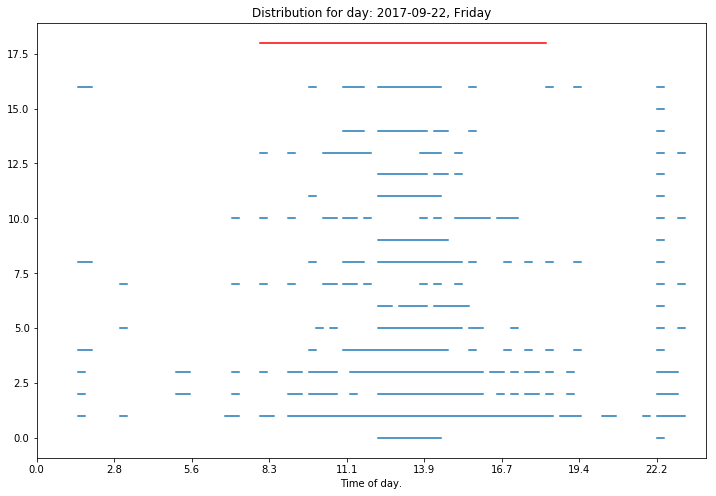

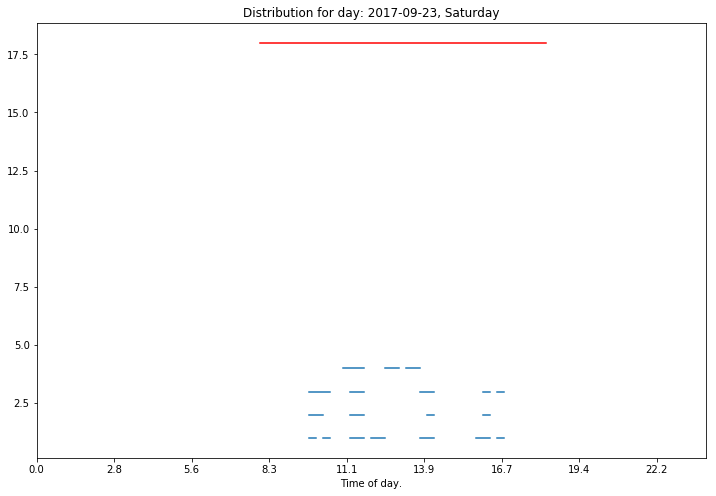

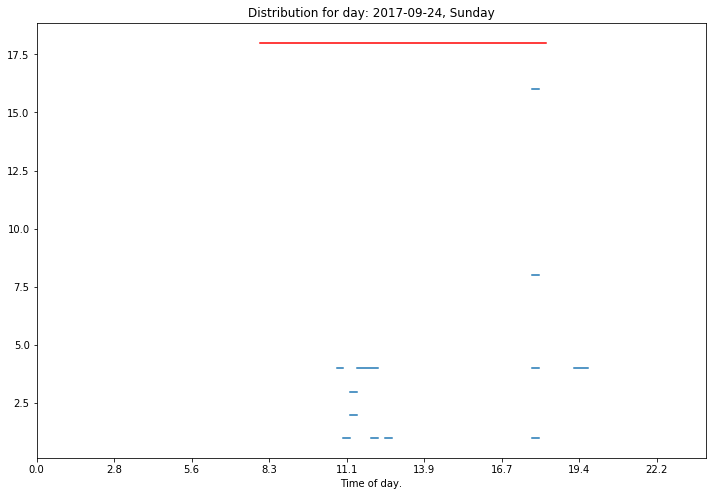

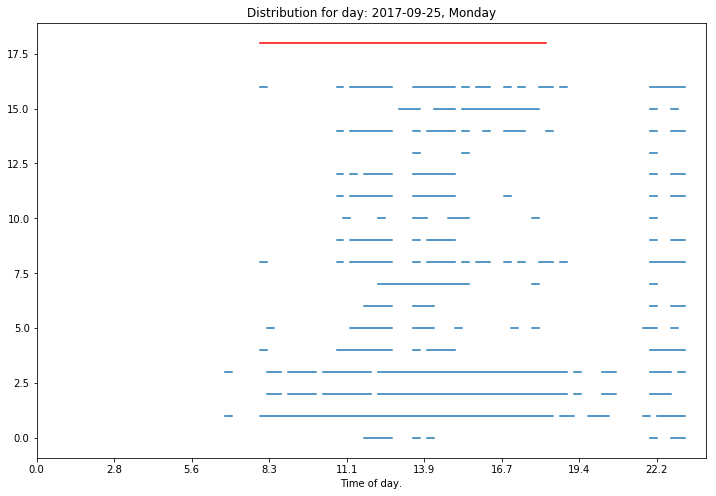

In [312]:
# Plots the distribution overlay for rooms in a zone.
plot_distribution_overlay(zone_df_data["SouthZone"].loc["2017-09-22":"2017-09-25"], compute_envelope())

In [15]:
# IMPROVE: on a room basis we can make this a helper function and jjust loop for each loop. 
# Maybe just return confusion matrix. Should be looked into.

def plot_confusion_matrix(data, env, time_step="15T", sensor=None):
    """Computes the confusion matrix for each day of a given week.
    Parameters:
            data: Should be a week of data.
            envelope: The prediction for each day.
            time_step: The time step to set all data to."""
    def assign_confusion(x):
        """If predicted and actualy YES then return 3.
            If predicted Yes and actual False return 2.
            If predicted False and actual True return 1
            If predicted False and actual False return 0"""
        if x["Envelope"] == 0:
            if x["Occupied"] == 0:
                return 0
            else:
                return 1
        if x["Occupied"] !=0:
            return 3
        return 2
    
    dates = data.index.normalize().unique().date
    confusion_matricies=defaultdict()
    # For each day, get the value from assign confusion to determine which confusion class it belongs to.
    for date in dates:
        data_use = data[data.index.map(lambda x: x.date == date)]
        env_use = pd.DataFrame(data=env.values, columns=["Envelope"], index=data_use.index)
        temp = pd.concat([data_use, env_use], axis=1)
        temp["Confusion"] = temp.apply(assign_confusion, axis=1)
        confusion_matricies[date] = temp["Confusion"].value_counts()
    # display the confusion matrix for each. Needed to Hard code which number belongs to which confusion class.    
    for day, confusion in confusion_matricies.items():
        zero = confusion[0] if 0 in confusion.keys() else 0
        one = confusion[1] if 1 in confusion.keys() else 0
        two = confusion[2] if 2 in confusion.keys() else 0
        three = confusion[3] if 3 in confusion.keys() else 0
        
        data = [[three, one], [two, zero]]
        row = ["Actual True", "Actual False"]
        column = ["Predicted True", "Predicted False"]
        fig = plt.figure(figsize=(3,1))
        ax = fig.add_subplot(111)
        ax.axis('off')
        the_table = ax.table(cellText=data, rowLabels=row, colLabels=column, loc='upper center')
        if sensor is not None:
            plt.title("Confusion Matrix for day: " + str(day) + "and sensor: "+ sensor)
        else:
            plt.title("Confusion Matrix for day: " + str(day))
        plt.show()

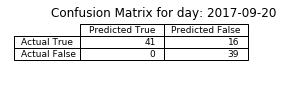

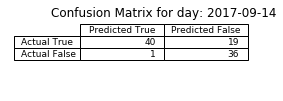

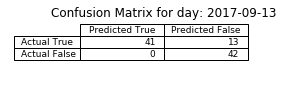

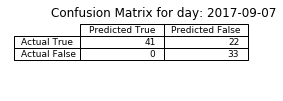

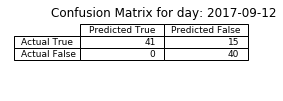

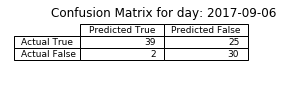

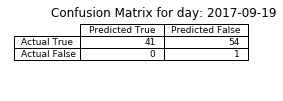

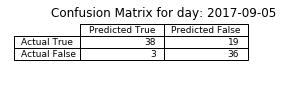

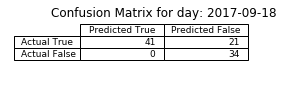

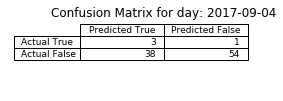

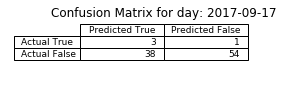

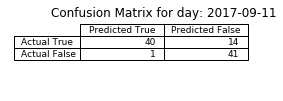

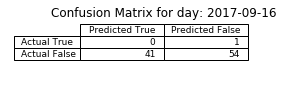

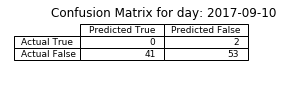

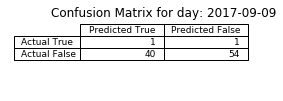

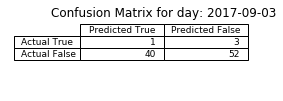

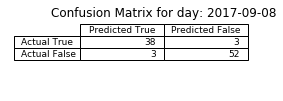

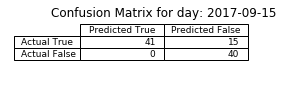

In [16]:
# Plot confusion matrix on a building basis. 
envelope = compute_envelope()
buildings= get_building_occupany()
d = buildings.loc["2017-09-03":"2017-09-20"]
plot_confusion_matrix(d, envelope)

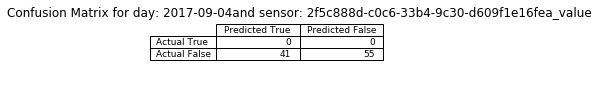

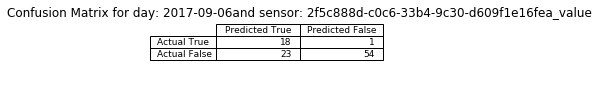

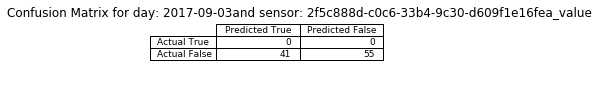

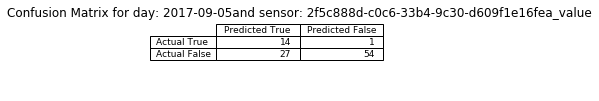

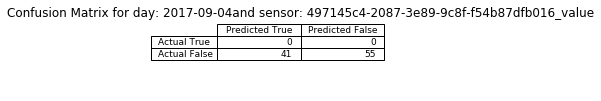

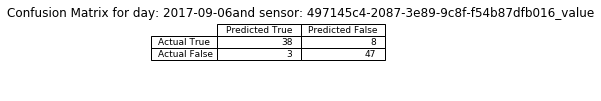

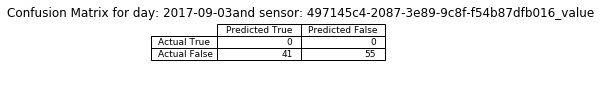

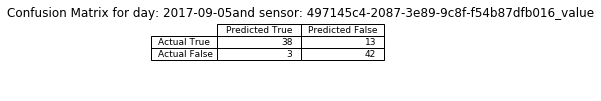

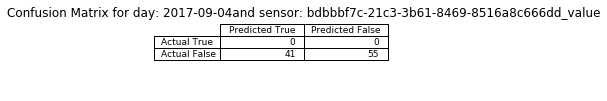

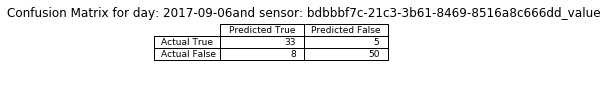

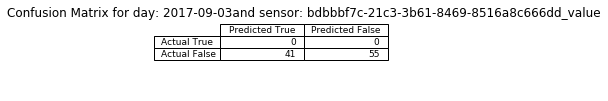

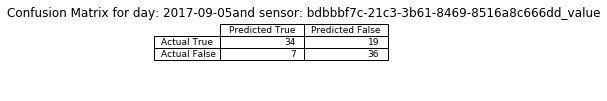

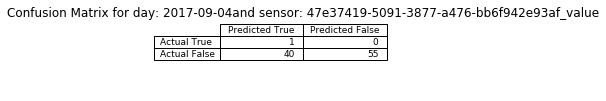

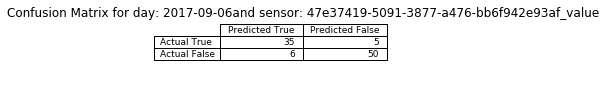

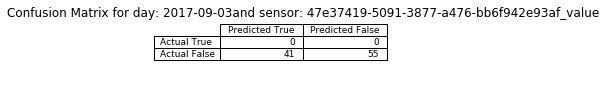

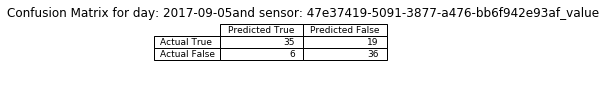

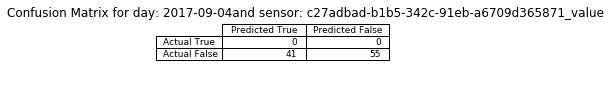

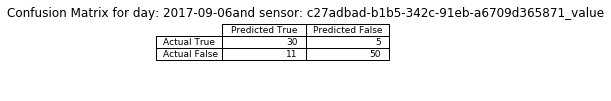

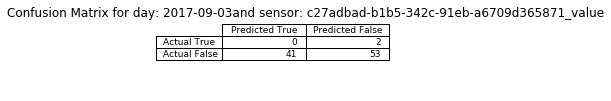

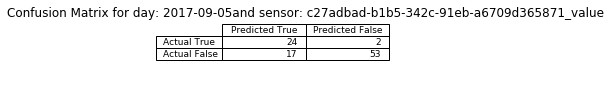

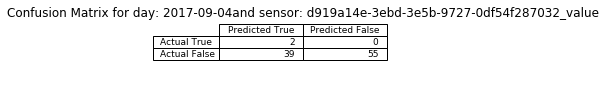

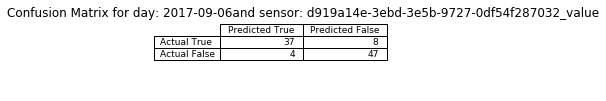

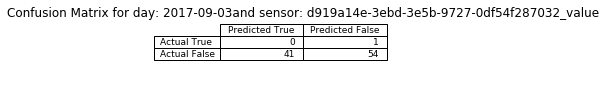

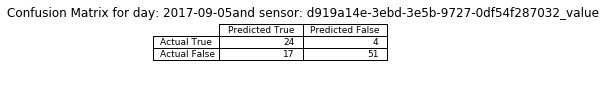

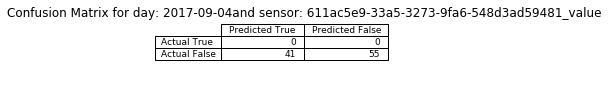

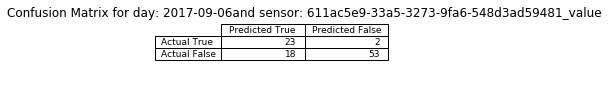

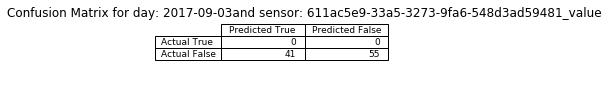

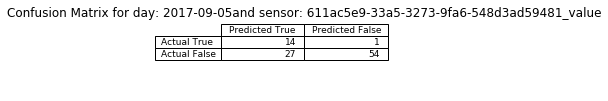

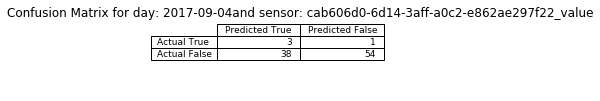

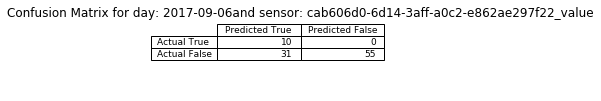

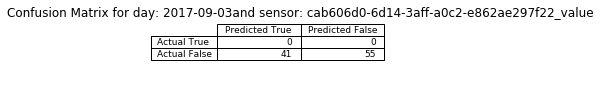

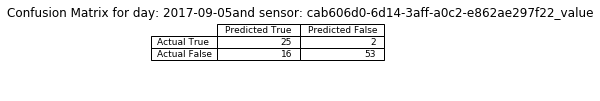

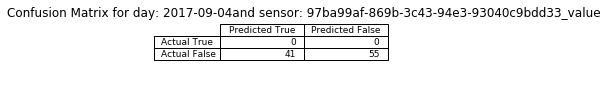

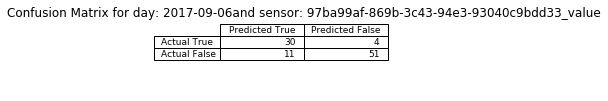

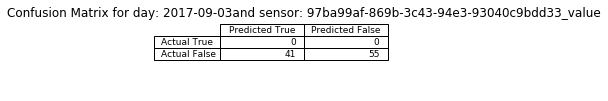

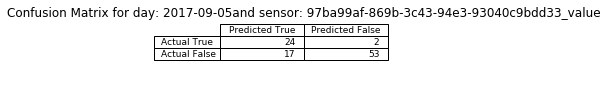

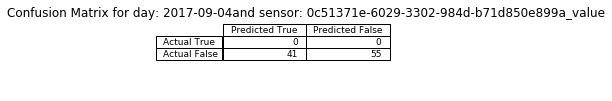

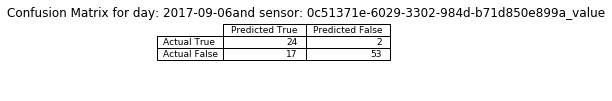

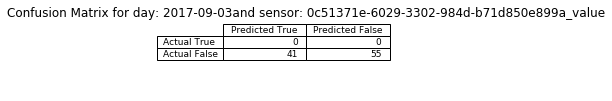

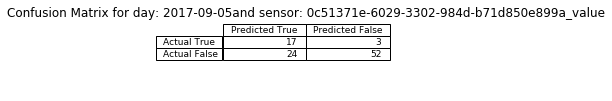

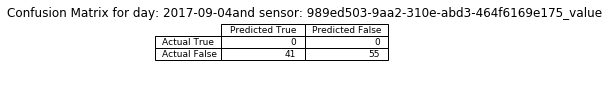

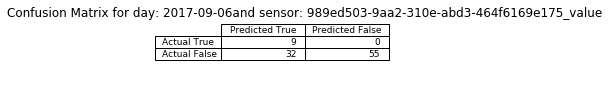

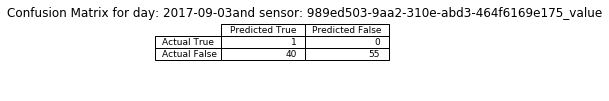

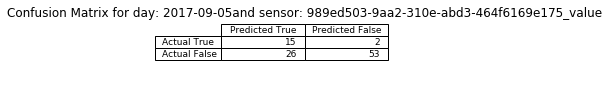

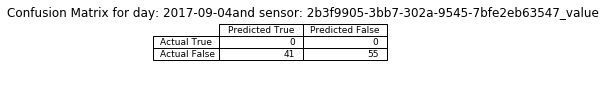

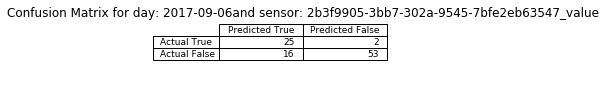

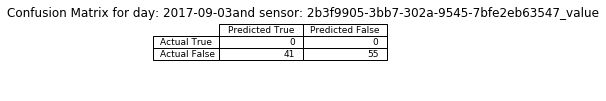

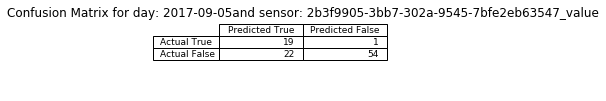

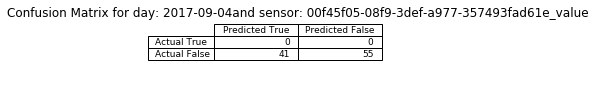

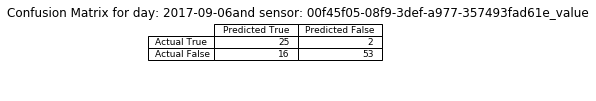

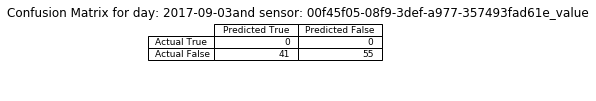

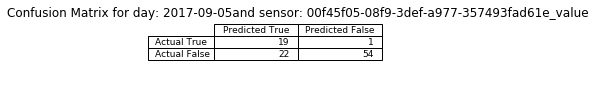

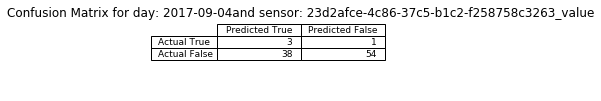

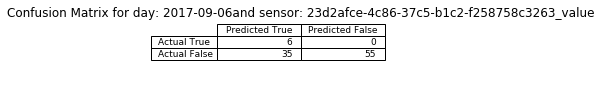

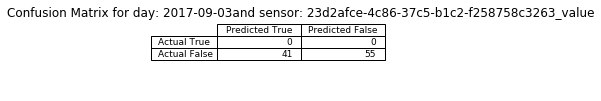

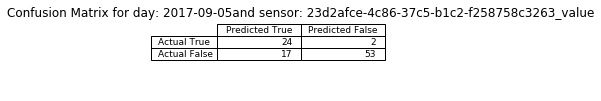

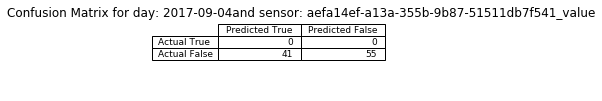

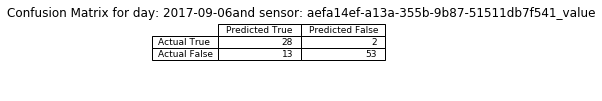

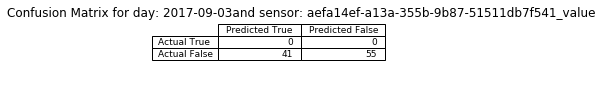

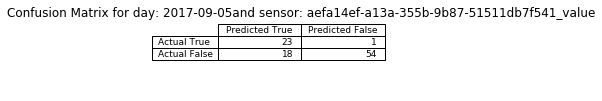

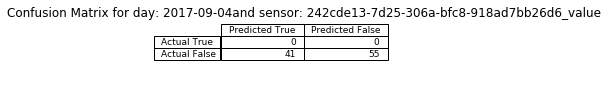

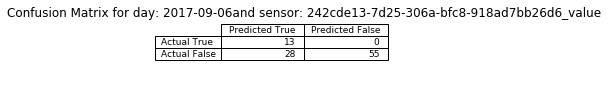

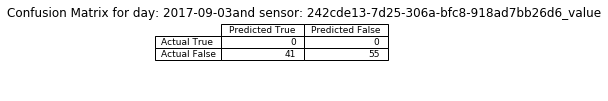

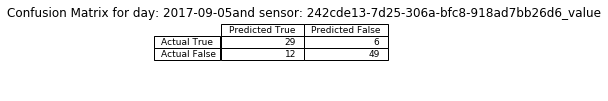

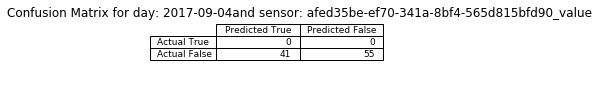

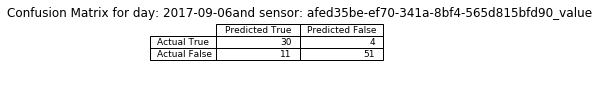

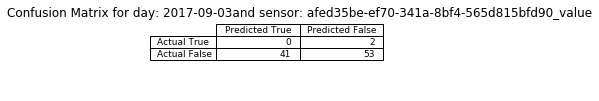

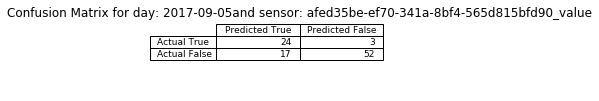

In [17]:
# Plot confusion matrix on a room basis for a zone.
data = zone_df_data["SouthZone"]
for c in data.columns:
    d = data[c].loc["2017-09-03":"2017-09-06"]
    d = pd.DataFrame(data=d.values, columns=["Occupied"], index = d.index)
    plot_confusion_matrix(d, envelope, sensor=c)
    

# Adaptive Schedule
Implement a scheduler which takes in an unlimated number of constraints which are all or'ed to get valid dates by which to find a schedule. All the valid days will be taken and put into a histogram. The Schedule will result of an On state if more than half of the days had occupancy at the time and Off when less than half had occupancy. Should be done for each HVAC zone.

In [191]:
def weekday_weekend(main_d, compare_d, num_c):
    """Checks wether main_d and compare_d are both either a weekday or a weekend day. Also checks that
    between the two, there aren't more than num_c days which are also weekdays/weekends (same class) depending on main_d.
    We will use a linear model for now to determine how similar a day is. Meaning, that if compare_d
    is num_c away from main_d, we will return 0.5.
    Parameters: 
            main_d: The date I want to compare everything with.
            compare_d: The day for which I want to see if it is in the same class as main_d.
            num_c: The max number of same class days between main_d and compare_d.
    Returns:
        An float. Representing how similar the day is to the given day. For now we will use a linear model."""
    num_c = float(num_c)
    temp_diff = (abs((main_d.date() - compare_d.date()).days) - main_d.weekday()) # Sets up how many days away compare_d is from the beginning of the week.
    num_weeks = temp_diff // 7 # number of weeks from beginning of the week
    if main_d.weekday() <= 4 and compare_d.weekday() <=4: # for weekdays
        remain = (temp_diff - 2) % 7 # adjusts it so i don't have to worry about weekends in the remainder
        if num_weeks < 0: # if negative, then I know that my compare_d is not more than a week away. So all days between are valid days.
            diff = num_c - abs((main_d.date() - compare_d.date()).days)
            return diff/num_c if diff > 0 else 0
        diff = num_c - (main_d.weekday() + num_weeks * 5 + remain) # check if the number of valid days in the weeks between, 
                                                                    #minus the days i subtracted for temp_diff, and the remainder days are not more than num_class days. 
        return diff/num_c if diff > 0 else 0
    elif main_d.weekday() > 4 and compare_d.weekday() > 4: # for weekends
        remain = 2 if (temp_diff%7) > 2 and num_weeks >= 0 else (temp_diff%7)
        if num_weeks < 0:
            diff = num_c - (abs((main_d.date() - compare_d.date()).days))
            return diff/num_c if diff > 0 else 0    
        diff = num_c - ((main_d.weekday() - 5) + num_weeks * 2 + remain)
        return diff/num_c if diff > 0 else 0
    return 0
        
        

def cond_adaptive(class_weight, num_same_class, num_same_day):
    """A condition function. Its purpose is to return a function which will be used as 
    a equivalence condition for a histogram. Assumes that any day has the format of a pandas Timestamp.
    To give weights, we will use a linear model, given what type of equivalence we achieve (day or class), we
    will give it a percentage weight of how far away it is from the possible distance (num_same_class or num_same_day)
    Parameters:
        class_weight: Function(main_day, compare_day, num_same_class) which decides if the two dates are in the same class (e.g. workdays or weekend days)
        num_same_class: The number of days that should be in the same class as the date. For current purposes
                        the same class means that they are weekdays/weekends.
        num_same_day: The number of days which are the same weekdays as my given date.
    Retruns:
        Function which has parameters (date_check, equivalence class). The equivalence class parameter will be set
            with the date for the adaptive 
            schedule. date_check is the date we pass in to see if it satisifies the equivalence relation."""
    def final_cond(d, e):
        """Returns a float weighting for the day we compare to the equivalence which is our main day. According
        to what we expect from the cond_adaptive function."""
        day_same = 4*int(d.weekday() == e.weekday())*(abs((d.date() - e.date()).days) / float(7*num_same_day))
        class_same = (class_weight(e, d, num_same_class))
        # want to give it the largest weight we get.
        # IS THIS DESIRABLE? SHOULD WE JUST RETURN THE SUM??
        if day_same > class_same:
            return day_same * int(d.date() != e.date())
        else:
            return class_same * int(d.date() != e.date())
    return final_cond
    

# IMPROVEMENT: Give it sort of learning rate. The further back the days are, the less they count. 
def adaptive_schedule(data, day, num_classes, num_same_days):
    """Will return an adaptive schedule for the given data, looking at the past data given. Produces an adaptive
    schedule depending on which days should be considered. For this purpose we will use same weekday and same classes
    (weekday or weekend day).
    Parameters:
        data: The data over which we find the schedule, should start the day before the given day. Is a pandas
            Dataframe with only one column or Pandas Series.
        day: A pd Timestamp day. We will generate the schedule for this day.
        num_same_class: The number of days that should be in the same class as the date. For current purposes
                    the same class means that they are weekdays/weekends.
        num_same_date: The number of days which are the same weekdays as my given date.
    Returns:
        A Pandas Series with True for having the schedule on and False for having it off."""
    his = compute_histogram(data=building, cond=cond_adaptive(weekday_weekend, 10, 10), equivalence_classes=[day])
    temp = his[day]
    schedule = 1*((temp[0] / float(max(temp[0]))) >= 0.50) # TODO need to reconsider what we are doing here. What should be the cutoff with variable weights?
    return schedule

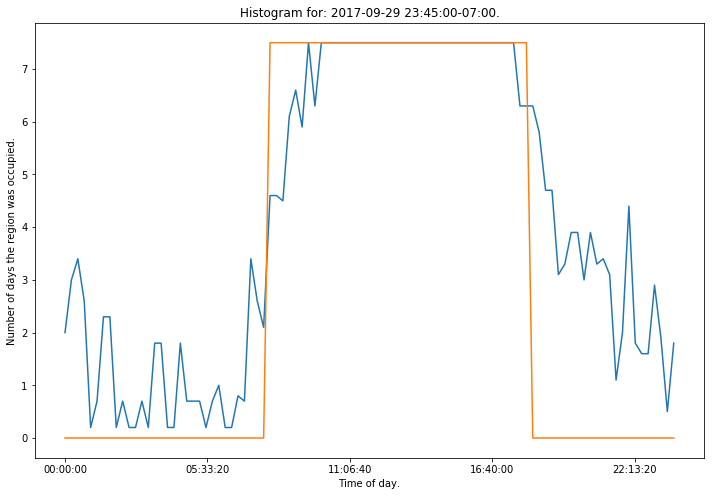

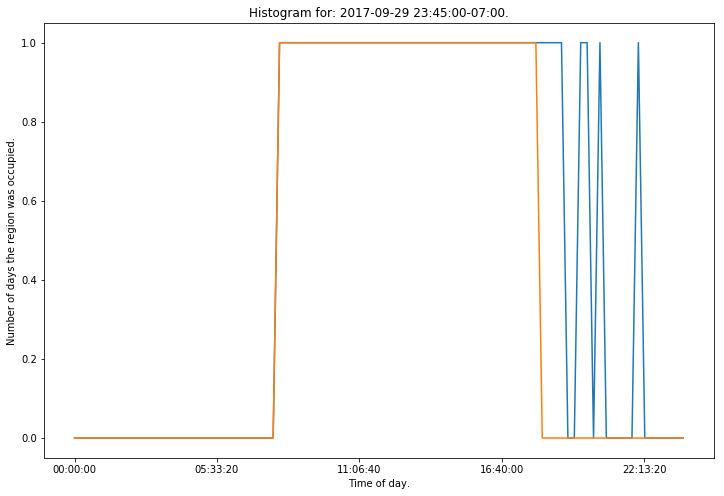

In [192]:
building = get_building_occupany()
day = building.index[-1]
# UNCOMMENT TO SEE ORIGINAL HISTOGRAM
his = compute_histogram(data=building, cond=cond_adaptive(weekday_weekend, 10, 10), equivalence_classes=[day])
plot_histogram(his=his, e_mapping={day:str(day)}, e=[day], plot_with_envelope=True)

schedule = adaptive_schedule(building, day, 10, 10)
plot_histogram(his={day: (schedule, 1)}, e_mapping={day:str(day)}, e=[day], plot_with_envelope=True)

In [161]:
building.index[-1].weekday()

4